# Baseline simulation
This is a Jupyter notebook execution of the default performance test simulation.

In [5]:
from COVID19.model import Model, Parameters
import COVID19.simulation as simulation

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

In [6]:
sim   = simulation.Simulation(env = model, end_time = 200 )
sim.steps( 200 )

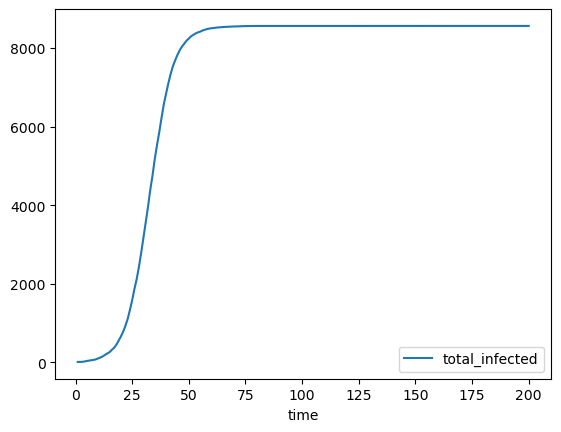

In [7]:
import pandas as pd
timeseries = pd.DataFrame( sim.results )
timeseries.plot( x = "time", y = "total_infected" )

## Extract network settings
We want to see how the probability of a person in each network becoming infected changes over time. Let us calculate the mean and variance for this probability for each network over the number of days in the simulation.

By default the model calculates the infectiousness hazard rate (the probability you will be infected by this interaction with this ill individual) from the network's combined transmission multiplier multiplied by the infector's infectiousness multiplier multipled by the strains infectiousness multiplied by the infectiousness for this strain on this day of infectiousness (i.e. the specific part of the infectiousness curve at this point in time). This is the interaction hazard value. See ../src/disease.c:111 transmit_virus_by_type() for details.

The strain infectious curve is a gamma_rate_curve distribution. See ../src/strain.c:42 initialise_infectious_curves(). This is static for a given day of being infectious as it's the same throughout the simulation for this strain.

The network transmission multiplier comes from a parameter for the simulation and is static throughout the simulation by the type of network. In the baseline parameters, for example, it is X for a household network, Y for a random network, and Z for a work network. See baseline_parameters.csv relative_transmission_household, relative_transmission_occupation, and relative_transmission_random parameters

The initial individual hazard probability is taken from the exponential distribution and is static for each individual throughout the whole simulation. This is divided by the adjusted susceptibility for that person's age group when setting up the simulation.

If the individual's static hazard value is less than this network interactions hazard value, then the individual is deemed to now be infected. See the new_infection() call in ../src/disease.c:174 transmit_virus_by_type() function.

All interactions throughout all networks of the same type thus have a static infectiousness multiplier which is only changed by the infectiousness of an individual in that network based on the number of days that individual has been infectious. Removing this from consideration, our network transmission multiplier values should be:-

Network | Mean Infectiousness | Variance of infectiousness
---|---|---
Work | 1 | 0
Home | 2 | 0
Random | 1 | 0

Let us try to calculate this from the model itself... (we'll calculate it over time even though we know its static so the code remains the same for future changes).


### Calculate mean and variance of infectiousness of all interactions across all networks of the same type
We expect to see the above table reproduced.
There will be no change to the number of infected.

WORK:     Count of networks:  200 , Mean:  1.0 , Variance:  0.0
HOME:     Count of networks:  200 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1000 , Mean:  1.0 , Variance:  0.0


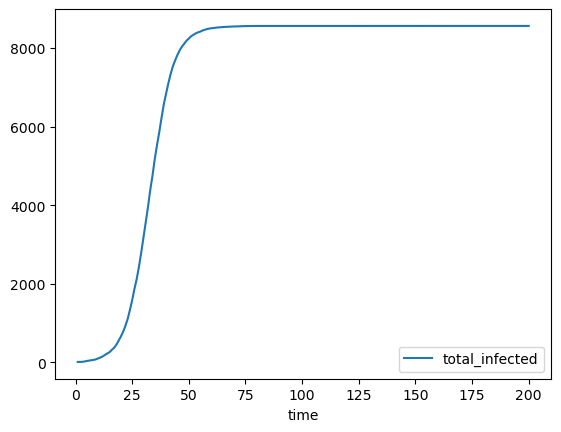

In [58]:
import numpy as np

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesBaseline = pd.DataFrame( sim.results )
timeseriesBaseline.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")

countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the multiplier to be completely random EVERY TIME from a uniform distribution
We expect to see a uniform distribution, and thus a mean of 0.5 and a standard deviation of 0.08333.
The overall number of infected may well change, as now the overall probability distribution across all interactions will be different from the three network types' fixed values.

WORK:     Count of networks:  200 , Mean:  0.4670654797879979 , Variance:  0.08666346621319185
HOME:     Count of networks:  200 , Mean:  0.9334115518361795 , Variance:  0.36479424722923404
RANDOM:   Count of networks:  1000 , Mean:  0.5128187930587447 , Variance:  0.08143961960387043


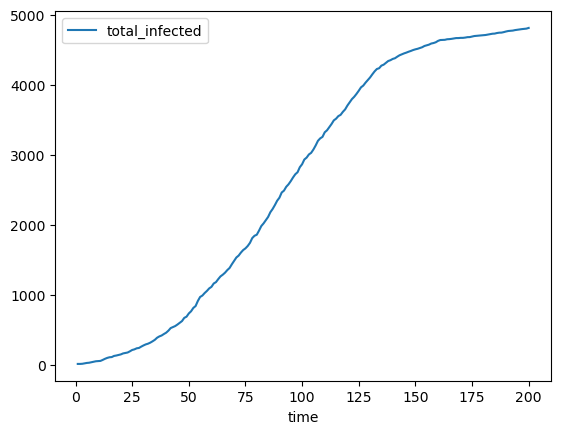

In [61]:
import numpy as np

from scipy.stats import uniform 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = uniform.rvs(0.0,1.0)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesUniform = pd.DataFrame( sim.results )
timeseriesUniform.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now do the same but from a Gamma distribution and random EVERY TIME
We expect to see the same mean and variance as the gamma distribution between (Shape 2, Beta 1).

We expect to see more infections earlier on due to the skewness of the CDF of the gamma distribution when compared to a uniform distribution.

WORK:     Count of networks:  200 , Mean:  0.9607014175376389 , Variance:  0.9277983843129377
HOME:     Count of networks:  200 , Mean:  2.154949661894352 , Variance:  4.237278799640234
RANDOM:   Count of networks:  1000 , Mean:  0.9766983765489422 , Variance:  0.9705630293215954


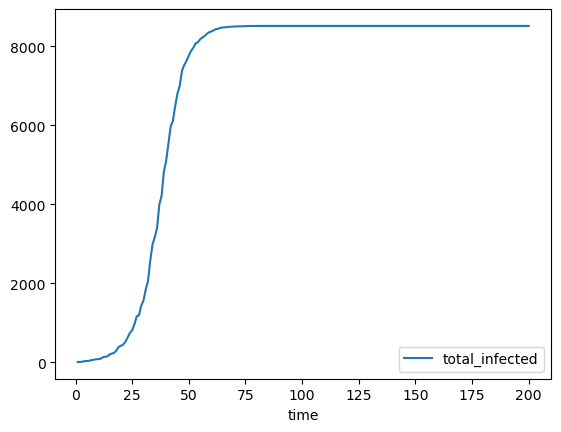

In [60]:
import numpy as np

from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = gamma.rvs(1)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesRandom.append(network.transmission_multiplier_combined())
        else:
            valuesWork.append(network.transmission_multiplier_combined())
                    
    
    # Run sim
    sim.steps(1)
    
timeseriesGamma = pd.DataFrame( sim.results )
timeseriesGamma.plot( x = "time", y = "total_infected" )

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the multiplier to be a weighting that's the same over time for each individual network
We now modify the simulation so the randomness of infection probability lies between being fixed per network type and random for every interaction for every network. We use the simulation parameter network transmissability number and modify it around a normal (Bernoulli) distribution from that value. I.e. it is weighted. We expect the mean to be the same as the parameter, but the variance to now be non zero. I shall choose a normal distribution around a mean of zero with +/- 1. (Final values less than 0 will be latched to 0, more than 1 will be latched to 1).
We expect the same output to be the same as the original simulation - i.e. the same population level number of infections over time. Individual networks' number of infections will vary more though.

### Now change the distribution of the network's weighting
We now select the hazard weighting value for each network from a Gamma distribution rather than normal, but keep it static for that network (but variable for that type of network) over the duration of the simulation. We therefore expect a mean of ? and a variance of ?, like the standard gamma distribution (0,1).
We expect more infections earlier on in the simulation given the skewed nature of the distribution, resulting in a more rapid pandemic spread.

### Weight the per network value for the type of network
We now modify the simulation such that the original network infectiousness parameter is reintroduced, but used to weight the infectiousness of each network when selected from a gamma distribution. We expect therefore to see the mean of each network type to return to the same as the baseline parameters, but the variance to be the same as the gamma distribution (0,1) rather than 0.
This should return the simulation to the same disease spread rate as the original fixed per network type probability, but with a more realistic affect within each network. I.e. some networks will now spread more readily than others, much like real workplaces where people are more or less confined close to each other. At a population level this should average out, but if not then we will have shown that the predominance of more infectious networks leads to a larger spread at the population level, and vice versa.